# Rossmann Store Sales

### Description

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

#### Files

train.csv - historical data including Sales

test.csv - historical data excluding Sales

sample_submission.csv - a sample submission file in the correct format

store.csv - supplemental information about the stores

### Data fields

* Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Importing the Packages

In [1]:
import numpy as np
import pandas as pd


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Reading the dataset

train_data = pd.read_csv("train.csv")
Test_data = pd.read_csv("test.csv")
Store_data = pd.read_csv("store.csv")

In [3]:
train_data.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [4]:
Store_data

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [5]:
Test_data.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


## Exploratory Data Analysis(EDA)

In [6]:
print(train_data.shape)
print(Store_data.shape)
print(Test_data.shape)

(1017209, 9)
(1115, 10)
(41088, 8)


In [7]:
print(train_data.dtypes,'\n')
print(Store_data.dtypes)

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object 

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


In [8]:
Test_data.dtypes

Id                 int64
Store              int64
DayOfWeek          int64
Date              object
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object

In [9]:
## Describing the data

train_data.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,2013-04-28,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


In [10]:
Store_data.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.00000,1115,1115,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.00000,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.00000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN
25%,279.50000,NaN,NaN,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN
50%,558.00000,NaN,NaN,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,NaN
75%,836.50000,NaN,NaN,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000,NaN


In [11]:
Test_data.describe(include='all')

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41088,41077.000000,41088.000000,41088,41088.000000
unique,NaN,NaN,NaN,48,NaN,NaN,2,NaN
top,NaN,NaN,NaN,2015-09-04,NaN,NaN,0,NaN
freq,NaN,NaN,NaN,856,NaN,NaN,40908,NaN
mean,20544.500000,555.899533,3.979167,NaN,0.854322,0.395833,NaN,0.443487
std,11861.228267,320.274496,2.015481,NaN,0.352787,0.489035,NaN,0.496802
min,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN,0.000000
25%,10272.750000,279.750000,2.000000,NaN,1.000000,0.000000,NaN,0.000000
50%,20544.500000,553.500000,4.000000,NaN,1.000000,0.000000,NaN,0.000000
75%,30816.250000,832.250000,6.000000,NaN,1.000000,1.000000,NaN,1.000000


In [12]:
## Checking for NULL Values

print(train_data.isna().sum(),'\n')
print(Store_data.isna().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [13]:
Test_data.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [14]:
train_data.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [15]:
train_data.loc[train_data['StateHoliday']==0,'StateHoliday']='0'

In [16]:
train_data.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [17]:
Test_data['StateHoliday'].value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

In [18]:
train_data['SchoolHoliday'].value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

In [19]:
Test_data['SchoolHoliday'].value_counts()

0    22866
1    18222
Name: SchoolHoliday, dtype: int64

In [20]:
train_data['Promo'].value_counts()

0    629129
1    388080
Name: Promo, dtype: int64

In [21]:
Test_data['Promo'].value_counts()

0    24824
1    16264
Name: Promo, dtype: int64

In [22]:
print("Train_data(open) :'\n'",train_data['Open'].value_counts(),'\n')
print("Test_data(open) :'\n'",Test_data['Open'].value_counts(),'\n')

Train_data(open) :'
' 1    844392
0    172817
Name: Open, dtype: int64 

Test_data(open) :'
' 1.0    35093
0.0     5984
Name: Open, dtype: int64 



## Feature Engineering

First Changing the Date column into Year/Month/Date format

Creating Day Month & Year Columns from the date column

In [23]:
train_data['Date'] = train_data['Date'].astype('datetime64')

In [24]:
train_data['Day'] = pd.DatetimeIndex(train_data['Date']).day
train_data['Month'] = pd.DatetimeIndex(train_data['Date']).month
train_data['Year'] = pd.DatetimeIndex(train_data['Date']).year

In [25]:
train_data.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,31,7,2015


In [26]:
## Re-Indexing the Columns in Dataframe

train_data = train_data.reindex(columns=['Store','Date','Day','Month','Year','DayOfWeek','Customers','Open','Promo','StateHoliday','SchoolHoliday','Sales'])

In [27]:
train_data.head()

,Store,Date,Day,Month,Year,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,1,2015-07-31,31,7,2015,5,555,1,1,0,1,5263
1,2,2015-07-31,31,7,2015,5,625,1,1,0,1,6064
2,3,2015-07-31,31,7,2015,5,821,1,1,0,1,8314
3,4,2015-07-31,31,7,2015,5,1498,1,1,0,1,13995
4,5,2015-07-31,31,7,2015,5,559,1,1,0,1,4822


In [28]:
train_data.dtypes

Store                     int64
Date             datetime64[ns]
Day                       int64
Month                     int64
Year                      int64
DayOfWeek                 int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
Sales                     int64
dtype: object

In [29]:
## Changing the datatypes of Columns

for i in ['Open','Promo','StateHoliday','SchoolHoliday']:
    train_data[i] = train_data[i].astype("category")

In [30]:
train_data.dtypes

Store                     int64
Date             datetime64[ns]
Day                       int64
Month                     int64
Year                      int64
DayOfWeek                 int64
Customers                 int64
Open                   category
Promo                  category
StateHoliday           category
SchoolHoliday          category
Sales                     int64
dtype: object

In [31]:
Test_data['Date'] = Test_data['Date'].astype('datetime64')

In [32]:
Test_data['Day'] = pd.DatetimeIndex(Test_data['Date']).day
Test_data['Month'] = pd.DatetimeIndex(Test_data['Date']).month
Test_data['Year'] = pd.DatetimeIndex(Test_data['Date']).year

In [33]:
Test_data.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
0,1,1,4,2015-09-17,1.0,1,0,0,17,9,2015
1,2,3,4,2015-09-17,1.0,1,0,0,17,9,2015


In [34]:
## Re-Indexing the Columns in Dataframe

Test_data = Test_data.reindex(columns=['Id','Store','Date','Day','Month','Year','DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday'])

In [35]:
Test_data.head()

,Id,Store,Date,Day,Month,Year,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,2015-09-17,17,9,2015,4,1.0,1,0,0
1,2,3,2015-09-17,17,9,2015,4,1.0,1,0,0
2,3,7,2015-09-17,17,9,2015,4,1.0,1,0,0
3,4,8,2015-09-17,17,9,2015,4,1.0,1,0,0
4,5,9,2015-09-17,17,9,2015,4,1.0,1,0,0


In [36]:
Test_data.dtypes

Id                        int64
Store                     int64
Date             datetime64[ns]
Day                       int64
Month                     int64
Year                      int64
DayOfWeek                 int64
Open                    float64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [37]:
## Changing the datatypes of Columns

for i in ['Open','Promo','StateHoliday','SchoolHoliday']:
    Test_data[i] = Test_data[i].astype("category")

In [38]:
Test_data.dtypes

Id                        int64
Store                     int64
Date             datetime64[ns]
Day                       int64
Month                     int64
Year                      int64
DayOfWeek                 int64
Open                   category
Promo                  category
StateHoliday           category
SchoolHoliday          category
dtype: object

### Analysing the Stores_data

In [39]:
Store_data['Promo2SinceYear'].value_counts()

2011.0    128
2013.0    120
2014.0     95
2012.0     81
2009.0     73
2010.0     64
2015.0     10
Name: Promo2SinceYear, dtype: int64

In [40]:
Store_data['Promo2SinceWeek'].value_counts()

14.0    81
40.0    77
31.0    44
10.0    42
5.0     39
37.0    35
1.0     35
45.0    34
13.0    34
22.0    33
18.0    29
35.0    25
9.0     14
27.0    11
36.0    10
48.0     9
39.0     6
23.0     5
44.0     3
49.0     1
6.0      1
26.0     1
50.0     1
28.0     1
Name: Promo2SinceWeek, dtype: int64

In [41]:
Store_data['CompetitionOpenSinceMonth'].value_counts()

9.0     125
4.0      94
11.0     92
3.0      70
7.0      67
12.0     64
10.0     61
6.0      50
5.0      44
2.0      41
8.0      39
1.0      14
Name: CompetitionOpenSinceMonth, dtype: int64

In [42]:
Store_data['CompetitionOpenSinceYear'].value_counts()

2013.0    83
2012.0    82
2014.0    70
2005.0    62
2010.0    55
2008.0    54
2011.0    54
2009.0    54
2007.0    48
2006.0    47
2015.0    38
2002.0    27
2004.0    22
2003.0    19
2001.0    16
2000.0    10
1999.0     8
1990.0     5
1995.0     2
1994.0     2
1900.0     1
1961.0     1
1998.0     1
Name: CompetitionOpenSinceYear, dtype: int64

In [43]:
Store_data['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

### Handling NULL values in Store_data

In [44]:
Store_data.loc[Store_data['Promo2']==0,'Promo2SinceWeek']=0

In [45]:
Store_data.loc[Store_data['Promo2']==0,'Promo2SinceYear']=0

In [46]:
Store_data.loc[Store_data['Promo2']==0,'PromoInterval']=0

In [47]:
## Converting in the LEVELS

Store_data['PromoInterval'] = Store_data['PromoInterval'].map({0:0, 'Jan,Apr,Jul,Oct':1, 'Feb,May,Aug,Nov':2, 'Mar,Jun,Sept,Dec':3})

In [48]:
Store_data['CompetitionDistance'] = Store_data['CompetitionDistance'].fillna(Store_data['CompetitionDistance'].mean())

In [49]:
Store_data['CompetitionOpenSinceYear'] = Store_data['CompetitionOpenSinceYear'].ffill().bfill()

In [50]:
Store_data['CompetitionOpenSinceMonth'] = Store_data['CompetitionOpenSinceMonth'].fillna(Store_data['CompetitionOpenSinceMonth'].median())

In [51]:
Store_data.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [52]:
Store_data.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
dtype: object

In [53]:
for i in ['StoreType','Assortment','Promo2','PromoInterval']:
    Store_data[i] = Store_data[i].astype('category')

In [54]:
Store_data.dtypes

Store                           int64
StoreType                    category
Assortment                   category
CompetitionDistance           float64
CompetitionOpenSinceMonth     float64
CompetitionOpenSinceYear      float64
Promo2                       category
Promo2SinceWeek               float64
Promo2SinceYear               float64
PromoInterval                category
dtype: object

In [55]:
Test_data['Open'].value_counts()

1.0    35093
0.0     5984
Name: Open, dtype: int64

In [56]:
Test_data['Open'].mode()

0    1.0
Name: Open, dtype: category
Categories (2, float64): [0.0, 1.0]

### Merging the train & store data

In [57]:
Train_merge = pd.merge(train_data,Store_data, on='Store', how='left')
Test_merge = pd.merge(Test_data,Store_data, on='Store', how='left')

In [58]:
Train_merge.head()

,Store,Date,Day,Month,Year,DayOfWeek,Customers,Open,Promo,StateHoliday,...,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2015-07-31,31,7,2015,5,555,1,1,0,...,5263,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,2015-07-31,31,7,2015,5,625,1,1,0,...,6064,a,a,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,2015-07-31,31,7,2015,5,821,1,1,0,...,8314,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,2015-07-31,31,7,2015,5,1498,1,1,0,...,13995,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,2015-07-31,31,7,2015,5,559,1,1,0,...,4822,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [59]:
Test_merge.head()

,Id,Store,Date,Day,Month,Year,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,2015-09-17,17,9,2015,4,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,3,2015-09-17,17,9,2015,4,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,1
2,3,7,2015-09-17,17,9,2015,4,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,0.0,0
3,4,8,2015-09-17,17,9,2015,4,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,0.0,0
4,5,9,2015-09-17,17,9,2015,4,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,0.0,0


In [60]:
print(Train_merge.shape)
print(Test_merge.shape)

(1017209, 21)
(41088, 20)


In [61]:
print(Train_merge.dtypes,'\n')
print(Test_merge.dtypes)

Store                                 int64
Date                         datetime64[ns]
Day                                   int64
Month                                 int64
Year                                  int64
DayOfWeek                             int64
Customers                             int64
Open                               category
Promo                              category
StateHoliday                       category
SchoolHoliday                      category
Sales                                 int64
StoreType                          category
Assortment                         category
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                             category
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                      category
dtype: object 

Id                                    int64
Store           

In [62]:
print(Train_merge.isna().sum(),'\n')
print(Test_merge.isna().sum())

Store                        0
Date                         0
Day                          0
Month                        0
Year                         0
DayOfWeek                    0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Sales                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64 

Id                            0
Store                         0
Date                          0
Day                           0
Month                         0
Year                          0
DayOfWeek                     0
Open                         11
Promo                         0
StateHoliday                  0
SchoolHoliday 

In [63]:
Train_merge['Year'].value_counts()

2013    406974
2014    373855
2015    236380
Name: Year, dtype: int64

In [64]:
Test_merge['Year'].value_counts()

2015    41088
Name: Year, dtype: int64

In [65]:
Test_merge['Open']=Test_merge['Open'].fillna(1)

### Visualization

Distribution Plot for Target Variable


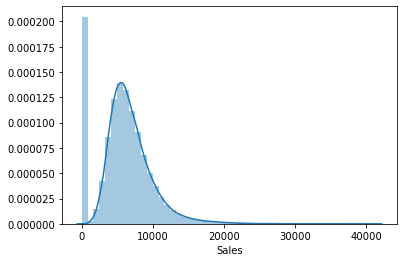

In [66]:
sns.distplot(Train_merge['Sales'])
print("Distribution Plot for Target Variable")

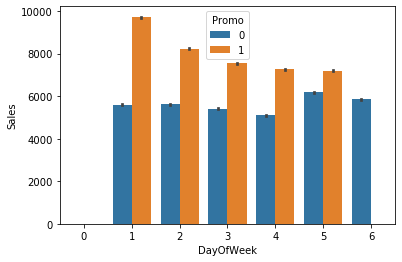

In [67]:
avg_hist_by_month = Train_merge[['Sales', 'Customers', 'Promo']].groupby(['Promo']).mean()
sns.barplot(x="DayOfWeek", y="Sales", hue="Promo", order=[0, 1, 2, 3, 4, 5, 6], data=Train_merge)

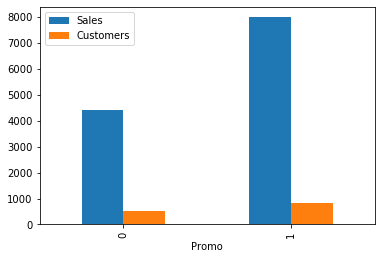

In [68]:
avg_promotion = Train_merge[['Sales', 'Customers', 'Promo']].groupby('Promo').mean()
avg_promotion.plot(kind='bar')

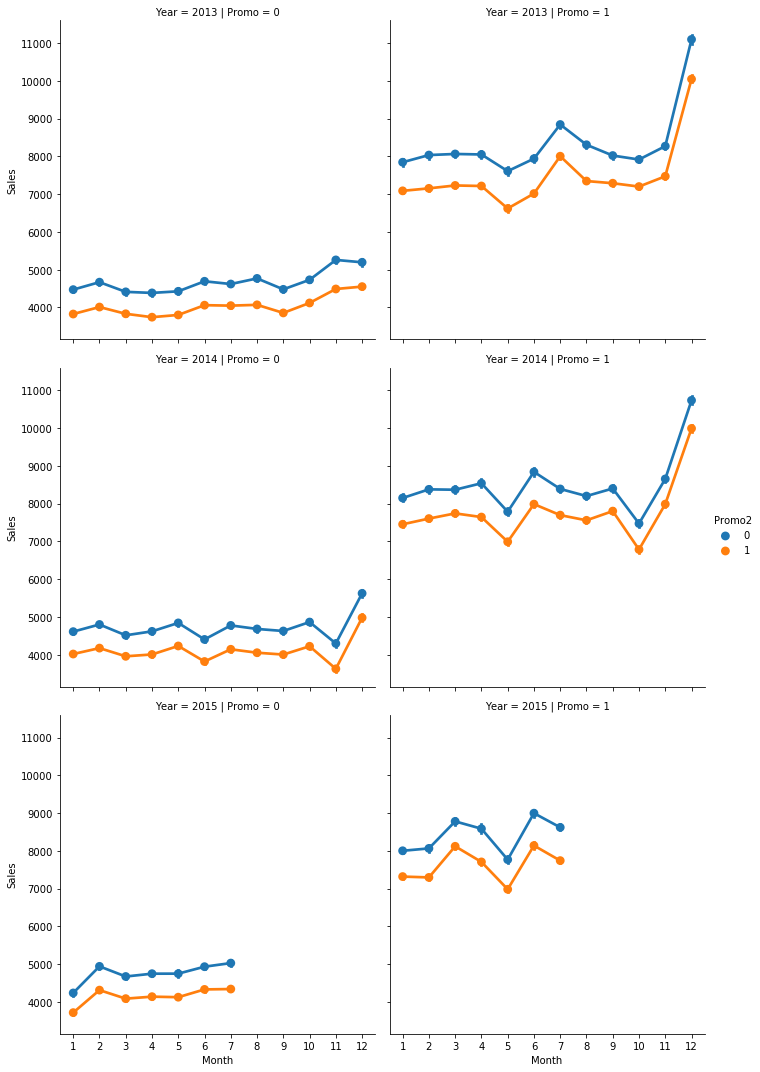

In [69]:
sns.factorplot(data = Train_merge, x ="Month", y = "Sales", col = 'Promo', hue = 'Promo2', row = "Year")

1
(942, 21)


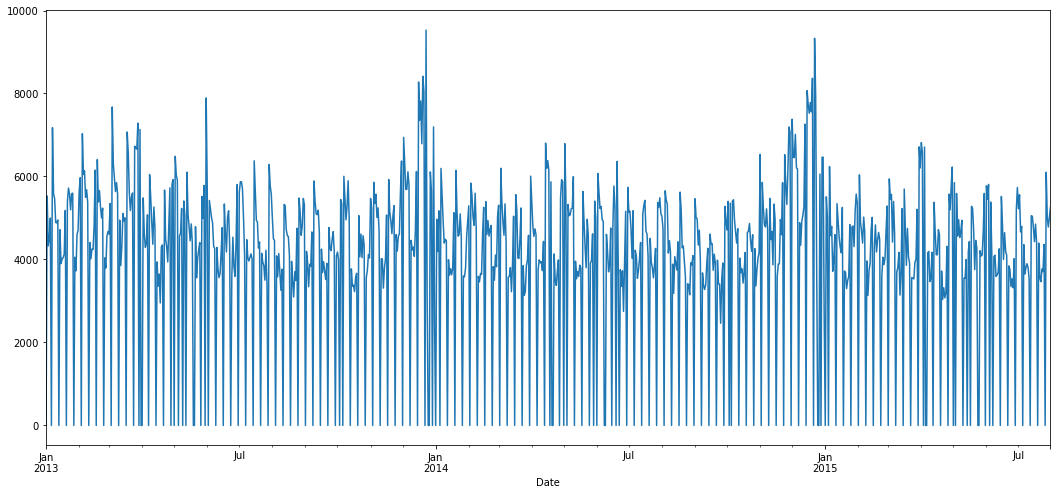

In [70]:
Train_merge['Date'] = pd.to_datetime(Train_merge['Date'],format = '%Y-%m-%d')
store_id = Train_merge.Store.unique()[0]
print(store_id)
store_rows = Train_merge[Train_merge['Store'] == store_id]
print(store_rows.shape)
store_rows.resample('1D',on = 'Date')['Sales'].sum().plot.line(figsize = (18,8))

## Dropping the Unnecessary Columns

In [71]:
print(Train_merge.columns,'\n')
print(Train_merge.shape)

Index(['Store', 'Date', 'Day', 'Month', 'Year', 'DayOfWeek', 'Customers',
       'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Sales', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object') 

(1017209, 21)


In [72]:
Train_merge.drop(columns=['Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear'], inplace=True)

In [73]:
Train_merge.shape

(1017209, 17)

In [74]:
print(Test_merge.columns)
print(Test_merge.shape)

Index(['Id', 'Store', 'Date', 'Day', 'Month', 'Year', 'DayOfWeek', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
(41088, 20)


In [75]:
Test_merge.drop(columns=['Id','Date','CompetitionOpenSinceMonth','CompetitionOpenSinceYear'], inplace=True)

In [76]:
Test_merge.shape

(41088, 16)

## One-to-One Corelation map

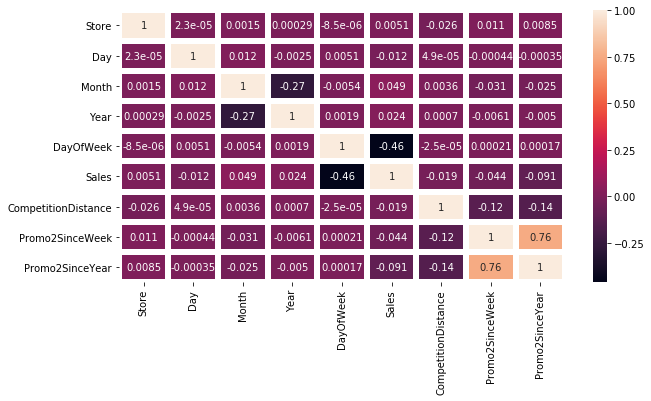

In [77]:
corr = Train_merge.corr()
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(corr,annot =True, linewidth = 5, cbar = True)

In [78]:
Train_merge = pd.get_dummies(Train_merge)

In [79]:
Train_merge.head(3)

,Store,Day,Month,Year,DayOfWeek,Sales,CompetitionDistance,Promo2SinceWeek,Promo2SinceYear,Open_0,...,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Promo2_0,Promo2_1,PromoInterval_0,PromoInterval_1,PromoInterval_2,PromoInterval_3
0,1,31,7,2015,5,5263,1270.0,0.0,0.0,0,...,0,1,0,0,1,0,1,0,0,0
1,2,31,7,2015,5,6064,570.0,13.0,2010.0,0,...,0,1,0,0,0,1,0,1,0,0
2,3,31,7,2015,5,8314,14130.0,14.0,2011.0,0,...,0,1,0,0,0,1,0,1,0,0


In [80]:
Test_merge = pd.get_dummies(Test_merge)
Test_merge.head(3)

,Store,Day,Month,Year,DayOfWeek,CompetitionDistance,Promo2SinceWeek,Promo2SinceYear,Open_0.0,Open_1.0,...,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Promo2_0,Promo2_1,PromoInterval_0,PromoInterval_1,PromoInterval_2,PromoInterval_3
0,1,17,9,2015,4,1270.0,0.0,0.0,0,1,...,0,1,0,0,1,0,1,0,0,0
1,3,17,9,2015,4,14130.0,14.0,2011.0,0,1,...,0,1,0,0,0,1,0,1,0,0
2,7,17,9,2015,4,24000.0,0.0,0.0,0,1,...,0,0,0,1,1,0,1,0,0,0


### Splitting Train & Test data

In [81]:
X = Train_merge.drop('Sales',axis=1)
Y = Train_merge['Sales']

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=456, test_size=0.3)

In [82]:
print(x_train.shape)
print(y_train.shape,'\n')

print(x_test.shape)
print(y_test.shape)

(712046, 31)
(712046,) 

(305163, 31)
(305163,)


## Model Building

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

### Linear Regression

In [84]:
lin_reg = LinearRegression()

In [85]:
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [86]:
lin_train_pred = lin_reg.predict(x_train)
lin_test_pred = lin_reg.predict(x_test)

In [87]:
print(lin_reg.score(x_train, y_train))
print(lin_reg.score(x_test, y_test))

0.570754668511662
0.570967331208006


In [88]:
def RMSPE_metrics(y_true, y_pred):
    error = (y_true - y_pred)/y_pred
    return np.sqrt(np.mean(error**2)*100)

In [89]:
lin_train_rmspe = RMSPE_metrics(y_train, lin_train_pred)
lin_test_rmspe = RMSPE_metrics(y_test, lin_test_pred)

In [90]:
print(lin_train_rmspe)
print(lin_test_rmspe)

5.444253039572805
5.455698027157764


In [91]:
#LIN_TEST_PRED = lin_reg.predict(Test_merge)

### Random Forest

In [92]:
RF = RandomForestRegressor()

In [94]:
RF_param_grid = {"n_estimators" : [5,10, 15], "max_depth" : [5,8],
               "max_features" : [3, 5],  "min_samples_leaf" : [4, 6]  }

RF_grid = GridSearchCV(RF, param_grid=RF_param_grid, cv=5)

In [96]:
RF_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [97]:
RF_train_pred = RF_grid.predict(x_train)
RF_test_pred = RF_grid.predict(x_test)

In [98]:
print(RF_grid.score(x_train, y_train))
print(RF_grid.score(x_test, y_test))

0.6230248372614613
0.6226138169445588


In [99]:
RF_train_rmspe = RMSPE_metrics(y_train, RF_train_pred)
RF_test_rmspe = RMSPE_metrics(y_test, RF_test_pred)

In [100]:
print(RF_train_rmspe)
print(RF_test_rmspe)

4.1729382314993915
4.193832233845867
